100%|██████████| 540/540 [00:09<00:00, 54.21it/s]

(10, 64)


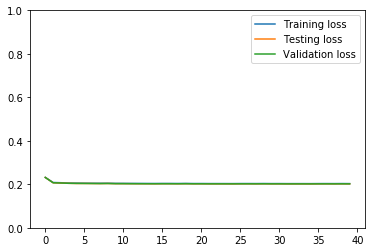

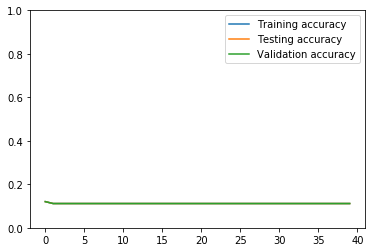

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import mnist
import tqdm

#mnist.init()
def should_early_stop(validation_loss, num_steps=3):
    if len(validation_loss) < num_steps+1:
        return False

    is_increasing = [validation_loss[i] <= validation_loss[i+1] for i in range(-num_steps-1, -1)]
    return sum(is_increasing) == len(is_increasing) 

def train_val_split(X, Y, val_percentage):
  """
    Selects samples from the dataset randomly to be in the validation set. Also, shuffles the train set.
    --
    X: [N, num_features] numpy vector,
    Y: [N, 1] numpy vector
    val_percentage: amount of data to put in validation set
  """
  dataset_size = X.shape[0]
  idx = np.arange(0, dataset_size)
  np.random.shuffle(idx) 
  
  train_size = int(dataset_size*(1-val_percentage))
  idx_train = idx[:train_size]
  idx_val = idx[train_size:]
  X_train, Y_train = X[idx_train], Y[idx_train]
  X_val, Y_val = X[idx_val], Y[idx_val]
  return X_train, Y_train, X_val, Y_val

def onehot_encode(Y, n_classes=10):
    onehot = np.zeros((Y.shape[0], n_classes))
    onehot[np.arange(0, Y.shape[0]), Y] = 1
    return onehot

def bias_trick(X):
    return np.concatenate((X, np.ones((len(X), 1))), axis=1)

def check_gradient(X, targets, w, epsilon, computed_gradient):
    print("Checking gradient...")
    dw = np.zeros_like(w)
    for k in range(w.shape[0]):
        for j in range(w.shape[1]):
            new_weight1, new_weight2 = np.copy(w), np.copy(w)
            new_weight1[k,j] += epsilon
            new_weight2[k,j] -= epsilon
            loss1 = cross_entropy_loss(X, targets, new_weight1)
            loss2 = cross_entropy_loss(X, targets, new_weight2)
            dw[k,j] = (loss1 - loss2) / (2*epsilon)
    maximum_abosulte_difference = abs(computed_gradient-dw).max()
    assert maximum_abosulte_difference <= epsilon**2, "Absolute error was: {}".format(maximum_abosulte_difference)

def softmax(a):
    a_exp = np.exp(a)
    return a_exp / a_exp.sum(axis=1, keepdims=True)

def sigmoid(X, w):
    return 1/(1+np.exp(-np.dot(X,w.T)))

def der_sigmoid(X,w):
    return np.dot(w.T,X)(1-np.dot(w.T,X));

def forward_softmax(X, w):
    a = X.dot(w.T)
    return softmax(a)

def feedforward(X, w1, w2):
    a_j = sigmoid(X,w1)
    output = forward_softmax(a_j, w2)
    return a_j, output

def calculate_accuracy(X, targets, w1, w2):
    [_, output] = feedforward(X, w1, w2)
    predictions = output.argmax(axis=1)
    targets = targets.argmax(axis=1)
    return (predictions == targets).mean()

def cross_entropy_loss(X, targets, w1, w2):
    [_, output] = feedforward(X, w1, w2)
    assert output.shape == targets.shape 
    #output[output == 0] = 1e-8
    log_y = np.log(output)
    cross_entropy = -targets * log_y
    return cross_entropy.mean()

def gradient_descent_softmax(A, targets, w, learning_rate, should_check_gradient):
    normalization_factor = A.shape[0] * targets.shape[1] # batch_size * num_classes
    outputs = forward(A, w)
    delta_k = - (targets - outputs)
    
    dw = delta_k.T.dot(A)
    dw = dw / normalization_factor # Normalize gradient equally as loss normalization
    assert dw.shape == w.shape, "dw shape was: {}. Expected: {}".format(dw.shape, w.shape)

    #if should_check_gradient:
        #check_gradient(X, targets, w, 1e-2,  dw)

    w = w - learning_rate * dw
    return w

def gradient_descent_sigmoid(X, a_j, outputs, targets, w1, learning_rate, should_check_gradient):
    normalization_factor = X.shape[0] * targets.shape[1] # batch_size * num_classes
    #outputs_hidden = sigmoid(X, w1)
    #outputs = forward(outputs_hidden, w2)
    d_sigmoid = (a_j*(1-a_j)).T
    delta_k = -(targets - outputs)
    delta_j = d_sigmoid*np.dot(w2.T,delta_k.T)
    

    dw = delta_j.dot(X)
    dw = dw / normalization_factor # Normalize gradient equally as loss normalization
    assert dw.shape == w1.shape, "dw shape was: {}. Expected: {}".format(dw.shape, w1.shape)

    #if should_check_gradient:
        #check_gradient(X, targets, w1, 1e-2,  dw)

    w1 = w1 - learning_rate * dw
    return w1

def backpropagate(X, a_j, outputs, targets, w1, w2, learning_rate, should_check_gradient):
    w2 = gradient_descent_softmax(a_j, targets, w2, learning_rate, should_check_gradient)
    w1 = gradient_descent_sigmoid(X, a_j, outputs, targets, w1, learning_rate, should_check_gradient)
    return w1 , w2

X_train, Y_train, X_test, Y_test = mnist.load()

# Pre-process data
X_train, X_test = (X_train / 127.5)-1, (X_test / 127.5)-1
X_train = bias_trick(X_train)
X_test = bias_trick(X_test)
Y_train, Y_test = onehot_encode(Y_train), onehot_encode(Y_test)

X_train, Y_train, X_val, Y_val = train_val_split(X_train, Y_train, 0.1)


# Hyperparameters

batch_size = 100
learning_rate = 5
num_batches = X_train.shape[0] // batch_size
should_check_gradient = True
check_step = num_batches // 10
max_epochs = 4

# Tracking variables
TRAIN_LOSS = []
TEST_LOSS = []
VAL_LOSS = []
TRAIN_ACC = []
TEST_ACC = []
VAL_ACC = []
def train_loop():
    weights_1 = np.zeros((64,785))
    weights_2 = np.zeros((10,64))
    for e in range(max_epochs): # Epochs
        for i in tqdm.trange(num_batches):
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            Y_batch = Y_train[i*batch_size:(i+1)*batch_size]
            
            #Feed forward
            [a_j, outputs] = feedforward(X_batch,weights_1,weights_2)
            
            #Backpropagation
            [weights_1,weights_2] = backpropagate(X_batch, a_j, outputs, Y_batch, weights_1, weights_2, learning_rate, should_check_gradient)

            
            if i % check_step == 0:
                # Loss
                                
                TRAIN_LOSS.append(cross_entropy_loss(X_train, Y_train, weights_1,weights_2))
                TEST_LOSS.append(cross_entropy_loss(X_test, Y_test, weights_1,weights_2))
                VAL_LOSS.append(cross_entropy_loss(X_val, Y_val, weights_1,weights_2))
                

                TRAIN_ACC.append(calculate_accuracy(X_train, Y_train, weights_1,weights_2))
                VAL_ACC.append(calculate_accuracy(X_train, Y_train, weights_1,weights_2))
                TEST_ACC.append(calculate_accuracy(X_train, Y_train, weights_1,weights_2))
                if should_early_stop(VAL_LOSS):
                    print(VAL_LOSS[-4:])
                    print("early stopping.")
                    return weights_1, weights_2
    return weights_1, weights_2


[w1, w2] = train_loop()

print(w2.shape)
plt.plot(TRAIN_LOSS, label="Training loss")
plt.plot(TEST_LOSS, label="Testing loss")
plt.plot(VAL_LOSS, label="Validation loss")
plt.legend()
plt.ylim([0, 1])
plt.show()

plt.clf()
plt.plot(TRAIN_ACC, label="Training accuracy")
plt.plot(TEST_ACC, label="Testing accuracy")
plt.plot(VAL_ACC, label="Validation accuracy")
plt.ylim([0, 1.0])
plt.legend()
plt.show()

#plt.clf()


#w1 = w1[:, :-1] # Remove bias
#w1 = w1.reshape(10, 28, 28)
#w1 = np.concatenate(w1, axis=0)
#plt.imshow(w1, cmap="gray")
#plt.show()


#w2 = w2[:, :-1] # No need to remove bias
#w2 = w2.reshape(10, 8, 8)
#w2 = np.concatenate(w2, axis=0)
#plt.imshow(w2, cmap="gray")
#plt.show()





